In [15]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [44]:
!dir german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pandas as pd
import random

In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [48]:
print(type(train_data))

<class 'dict'>


In [0]:
x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']

In [50]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(x_train.shape[0] == y_train.shape[0]), "Number of images is not equal to no of labels"
assert(x_val.shape[0] == y_val.shape[0]), "Number of images is not equal to no of labels"
assert(x_test.shape[0] == y_test.shape[0]), "Number of images is not equal to no of labels"
assert(x_train.shape[1:] == (32,32,3)), "Shape of training data is not 32*32*3"
assert(x_val.shape[1:] == (32,32,3)), "Shape of training data is not 32*32*3"
assert(x_test.shape[1:] == (32,32,3)), "Shape of training data is not 32*32*3"

In [52]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
data

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


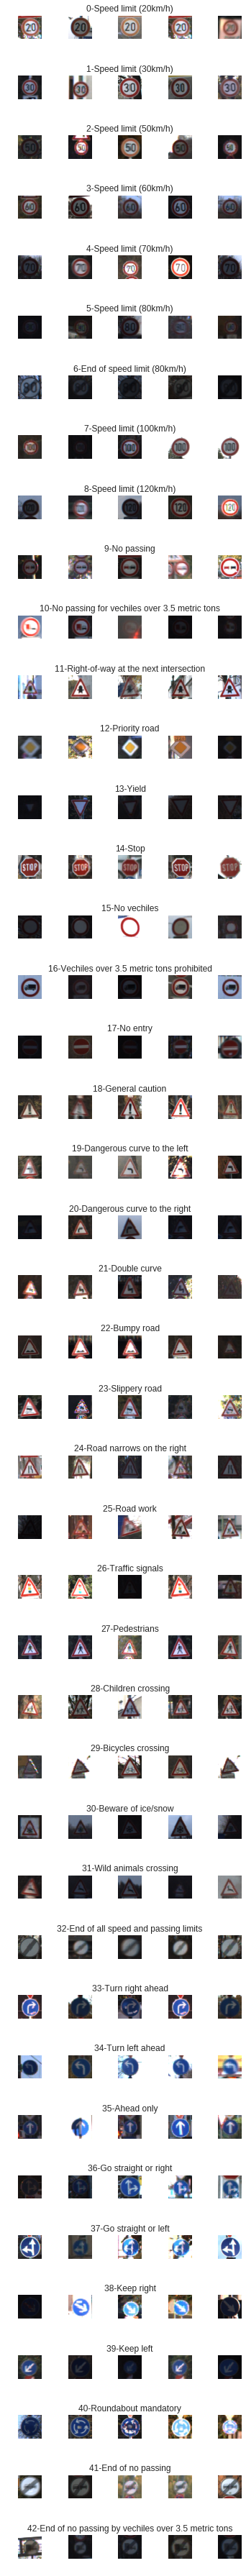

In [53]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,len(x_selected)- 1),:, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'no of images')

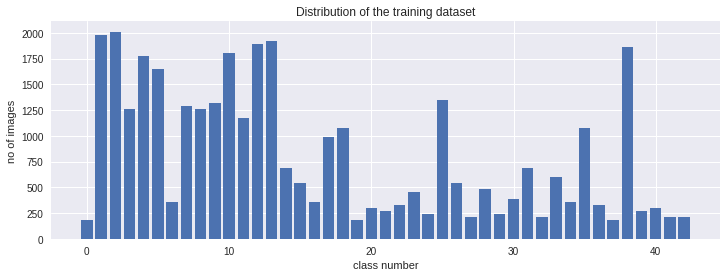

In [54]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,num_classes),num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("class number")
plt.ylabel("no of images")

(32, 32, 3)
ClassId                       36
SignName    Go straight or right
Name: 36, dtype: object


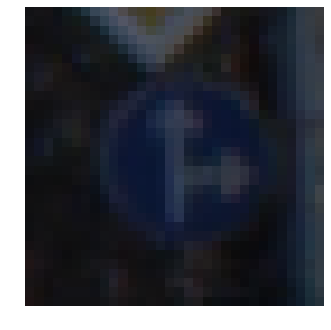

In [55]:
import cv2 
plt.imshow(x_train[1000])
plt.axis("off")
print(x_train[1000].shape)
print(data.iloc[y_train[1000]])

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


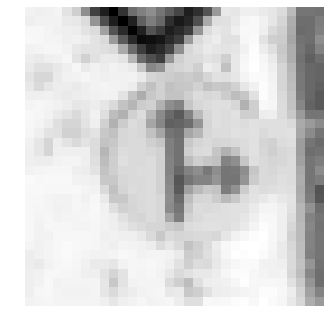

In [57]:
img = grayscale(x_train[1000])

plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


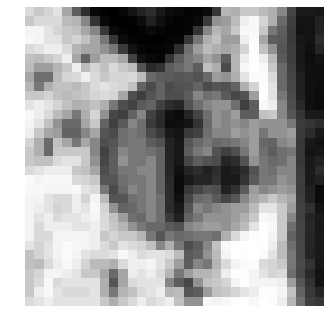

In [58]:
#to have similar lighting effect in background
def equalize(img):
    img = cv2.equalizeHist(img)
    return img# only grayscale images

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255 #normalizing the input
    return img

In [0]:
x_train = np.array(list(map(preprocessing, x_train)))
x_val= np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))

(34799, 32, 32)


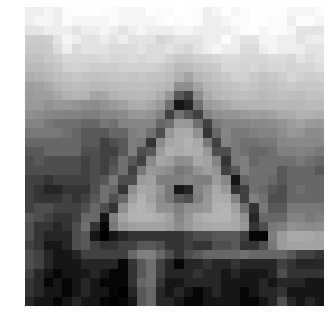

In [61]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)],cmap = 'gray')
plt.axis("off")
print(x_train.shape)

In [0]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen  = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
datagen.fit(x_train)

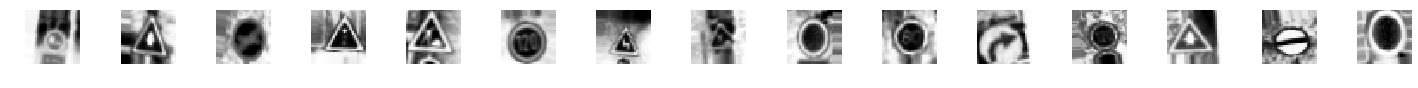

In [64]:
batches = datagen.flow(x_train, y_train, batch_size = 20)
x_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize = (20,5))
fig.tight_layout()
for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32,32))
  axs[i].axis("off")

In [65]:
x_train.shape

(34799, 32, 32, 1)

In [0]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

In [0]:
def model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape = (32,32,1), activation = 'relu')) #no need to ad padding as our image is centralized
    model.add(Conv2D(60, (5,5), input_shape = (32,32,1), activation = 'relu')) #no need to ad padding as our image is centralized
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30, (3,3), activation = 'relu'))
    model.add(Conv2D(30, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.5))

    
    model.add(Flatten()) # to convert 6*6*15 to 1D array
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model


In [68]:
model = model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 480)               0         
__________

In [69]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data = (x_val,y_val), shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 52s 26ms/step - loss: 0.8445 - acc: 0.7536 - val_loss: 0.0894 - val_acc: 0.9712
Epoch 2/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.2001 - acc: 0.9380 - val_loss: 0.0472 - val_acc: 0.9868
Epoch 3/10
2000/2000 [==============================] - 51s 25ms/step - loss: 0.1327 - acc: 0.9588 - val_loss: 0.0439 - val_acc: 0.9889
Epoch 4/10
2000/2000 [==============================] - 51s 26ms/step - loss: 0.1082 - acc: 0.9666 - val_loss: 0.0284 - val_acc: 0.9905
Epoch 5/10
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0909 - acc: 0.9723 - val_loss: 0.0252 - val_acc: 0.9948
Epoch 6/10
2000/2000 [==============================] - 48s 24ms/step - loss: 0.0794 - acc: 0.9754 - val_loss: 0.0380 - val_acc: 0.9912
Epoch 7/10
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0713 - acc: 0.9783 - val_loss: 0.0203 - val_acc: 0.9950
Epoch 8/10
2000/2000 [==========================

In [0]:
model.save('trained_model.h5')

In [0]:
from google.colab import files
files.download('trained_model.h5')

Text(0.5, 0, 'epoch')

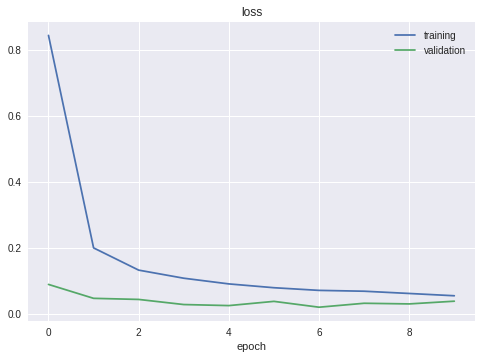

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

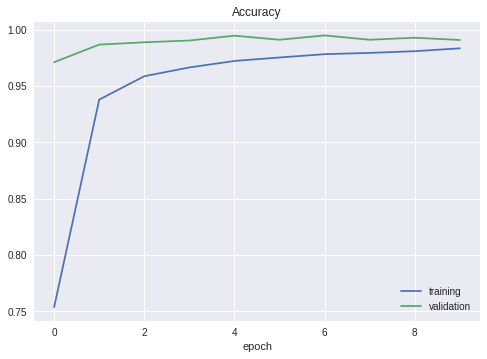

In [73]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [74]:
score = model.evaluate(x_test, y_test, verbose = 0)

print("Test score:", score[0])# loss 
print("Test Accuracy:", score[1])

Test score: 0.14141062668977994
Test Accuracy: 0.9671417260679667


In [0]:
# since from the graph, we can see that our validation data is high in terms of loss and low in terms of accuracy, that means that we are overfitting the training data.
# an also accuracy is too low.

In [0]:
#After fine tuning model,we can see that we have avoided the problem of overfitting as validation loss is less than training loss, and our validation accuracy is more than training accuracy

TESTING THE MODEL WITH REAL IMAGES

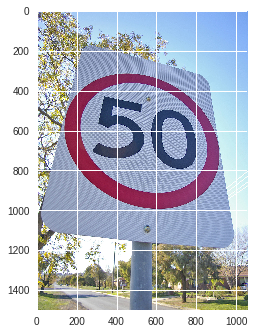

In [77]:
import requests
from PIL import Image
url = 'https://upload.wikimedia.org/wikipedia/commons/9/9d/50km_speedlimit.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


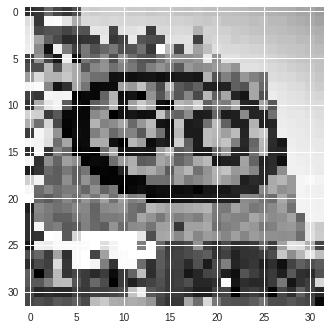

In [78]:

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [79]:

img = img.reshape(1, 32, 32, 1)
 

print("predicted sign index: "+ str(model.predict_classes(img)))
print("Predicted sign: " + data.iloc[model.predict_classes(img)[0]]['SignName'])

predicted sign index: [2]
Predicted sign: Speed limit (50km/h)


### IF THE MODEL IS NOT PERFORMING VERY WELL ON  IMAGES FROM INTERNET,  we go for data augmentation or fit generator.